# Building DNN and Calculating Gradients

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Loading the Dataset

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Making the model with 300 layers and relu activation

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

Finding the Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


Defining the Loss Function

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

Training the model

In [ ]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2402 - accuracy: 0.9297
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1112 - accuracy: 0.9657
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0762 - accuracy: 0.9767
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0610 - accuracy: 0.9807
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0490 - accuracy: 0.9841


In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0715 - accuracy: 0.9770


[0.07147829979658127, 0.9769999980926514]

Recording the initial accuracy over clean images

In [ ]:
accuracyofmodel = np.argmax(model.predict(x_test), axis=-1)
accuracyrate = 0

for i in range(len(accuracyofmodel)):
  if accuracyofmodel[i] == y_test[i]:
    accuracyrate = accuracyrate+1
  else:
    accuracyrate = accuracyrate+0
accuracyrate = accuracyrate/10000
print(accuracyrate)

0.977


Building the initial signed gradient

In [ ]:
image_tensor = tf.convert_to_tensor(x_test,dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(image_tensor)
    output = model(image_tensor)
    loss = loss_fn(y_test, output)
gradient = tape.gradient(loss, image_tensor)
signed_grad = tf.sign(gradient)


# Conducting Untargeted FGSM Attacks

Defining the attack:

0.00392156862745098
313/313 - 0s - loss: 0.0902 - accuracy: 0.9709


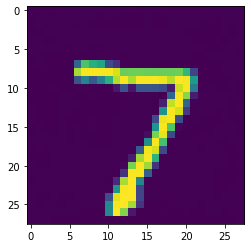

epsilon,accuracy 0.00392156862745098 0.006243602865916076
0.0196078431372549
313/313 - 0s - loss: 0.2593 - accuracy: 0.9219


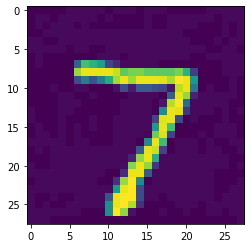

epsilon,accuracy 0.0196078431372549 0.05639713408393032
0.0392156862745098
313/313 - 0s - loss: 1.4489 - accuracy: 0.5958


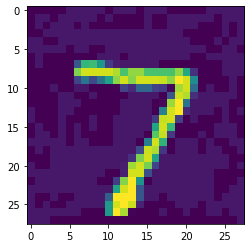

epsilon,accuracy 0.0392156862745098 0.39017400204708286
0.0784313725490196
313/313 - 0s - loss: 6.6822 - accuracy: 0.0958


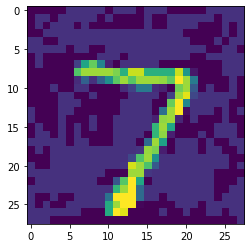

epsilon,accuracy 0.0784313725490196 0.9019447287615149
0.11764705882352941
313/313 - 0s - loss: 14.7174 - accuracy: 0.0115


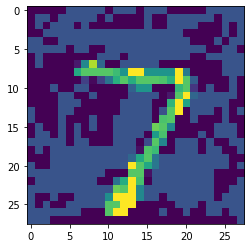

epsilon,accuracy 0.11764705882352941 0.9882292732855681
0.1568627450980392
313/313 - 0s - loss: 26.6868 - accuracy: 7.0000e-04


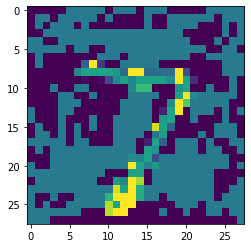

epsilon,accuracy 0.1568627450980392 0.9992835209825998
0.19607843137254902
313/313 - 0s - loss: 43.5855 - accuracy: 3.0000e-04


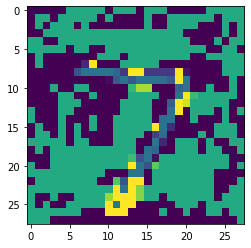

epsilon,accuracy 0.19607843137254902 0.9996929375639714
[ 0.62436029  5.63971341 39.0174002  90.19447288 98.82292733 99.9283521
 99.96929376]


In [ ]:
epsilon = [1,5,10,20,30,40,50]
new_epsilon = [0,0,0,0,0,0,0]
#Dividing each epsilon over 255
for j in range(len(epsilon)):
  new_epsilon[j] = epsilon[j]/255

accuracyuntargeted = np.zeros(shape=(len(epsilon)))
adversarial_array = x_test
adversarial_arrayLabel = y_test
for i in range(len(epsilon)):
  accuracy = 0
  print(new_epsilon[i])
  for k in range(len(x_test)):
    image = x_test[k]  
    #Using formula from the slides to run untargeted attack
    adversarial_array[k] = image + signed_grad[k]*new_epsilon[i]
    adversarial_array[k] = tf.clip_by_value(adversarial_array[k], 0, 1)
    adversarial_arrayLabel[k] = y_test[k]
  #Finding the sucessrate of the attack over the model
  model.evaluate(adversarial_array,  adversarial_arrayLabel, verbose=2)
  #Building the prediction matrix
  untargeted_predictions = np.argmax(model.predict(adversarial_array), axis=-1)
  for l in range(len(y_test)):
    if untargeted_predictions[l] == adversarial_arrayLabel[l]:
      #Counting the number of correctly predicted images despite the attack
      accuracy = accuracy+1
    else:
      accuracy = accuracy+0
  testacc = accuracy/10000
  #Calculating the success rate of the attack by finding the number of images correctly classified before the attack v/s after te attack
  attackacc = 1 - testacc/accuracyrate
  plt.imshow(adversarial_array[0])
  plt.show()
  accuracyuntargeted[i] = attackacc*100
  print("epsilon,accuracy",new_epsilon[i],attackacc)

print(accuracyuntargeted)

# Conducting Targeted FGSM attacks

Redefining x_test to ensure only clean images are used

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Building the matrix for target classes

In [ ]:
targetclasses = np.zeros(shape=len(y_test))
for i in range(len(y_test)):
  targetclasses[i] = (y_test[i]+1)%10
 


Calculating the gradient with respect to target classes

In [ ]:
image_tensor2 = tf.convert_to_tensor(x_test,dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(image_tensor2)
    output2 = model(image_tensor2)
    loss2 = loss_fn(targetclasses, output2)
gradient2 = tape.gradient(loss2, image_tensor2)
signed_grad2 = tf.sign(gradient2)

Running the targeted attack which is a modified version of the untargeted attack.

**Disclaimer: Sometimes the labels may not appear as expected, correct labeling happens at the fourth epsilon(20/255) value. If this error occurs please restart and run notebook again twice or thrice**

0.00392156862745098
313/313 - 0s - loss: 0.0729 - accuracy: 0.9761
Prediction of Sample: 7 Correct Label of Sample: 7


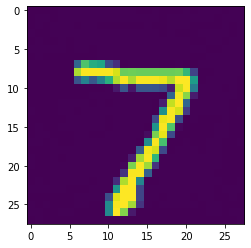

epsilon,accuracy 0.00392156862745098 0.0009211873080859911
0.0196078431372549
313/313 - 0s - loss: 0.1107 - accuracy: 0.9627
Prediction of Sample: 7 Correct Label of Sample: 7


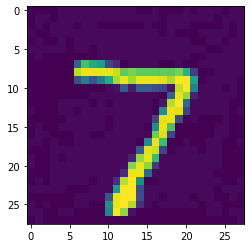

epsilon,accuracy 0.0196078431372549 0.01463664278403276
0.0392156862745098
313/313 - 0s - loss: 0.6824 - accuracy: 0.7712
Prediction of Sample: 7 Correct Label of Sample: 7


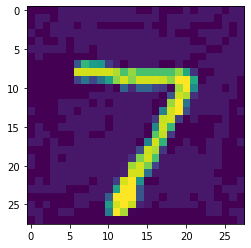

epsilon,accuracy 0.0392156862745098 0.21064483111566012
0.0784313725490196
313/313 - 0s - loss: 4.7944 - accuracy: 0.2081
Prediction of Sample: 8 Correct Label of Sample: 7


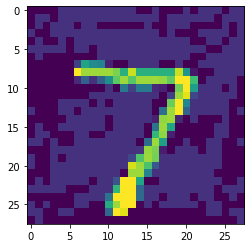

epsilon,accuracy 0.0784313725490196 0.7870010235414534
0.11764705882352941
313/313 - 0s - loss: 12.5534 - accuracy: 0.0098
Prediction of Sample: 8 Correct Label of Sample: 7


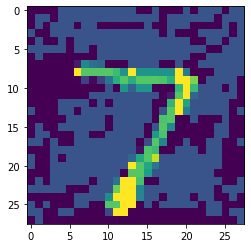

epsilon,accuracy 0.11764705882352941 0.9899692937563971
0.1568627450980392
313/313 - 0s - loss: 24.4505 - accuracy: 5.0000e-04
Prediction of Sample: 8 Correct Label of Sample: 7


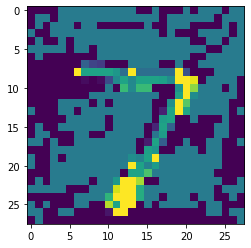

epsilon,accuracy 0.1568627450980392 0.9994882292732856
0.19607843137254902
313/313 - 0s - loss: 41.2717 - accuracy: 3.0000e-04
Prediction of Sample: 8 Correct Label of Sample: 7


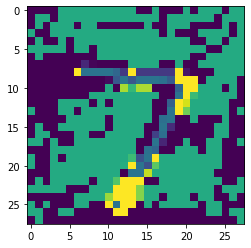

epsilon,accuracy 0.19607843137254902 0.9996929375639714
[9.21187308e-02 1.46366428e+00 2.10644831e+01 7.87001024e+01
 9.89969294e+01 9.99488229e+01 9.99692938e+01]


In [ ]:
accuracytargeted = np.zeros(shape=(len(epsilon)))
adversarial_arraytarget = x_test
targetLabel = y_test
for i in range(len(epsilon)):
  accuracy = 0
  print(new_epsilon[i])
  for k in range(len(x_test)):
    image = x_test[k]  
    #Using formula from the slides to caonduct the targeted fgsm attack 
    adversarial_arraytarget[k] = image - signed_grad2[k]*new_epsilon[i]
    adversarial_arraytarget[k] = tf.clip_by_value(adversarial_arraytarget[k], 0, 1)
    targetLabel[k]=y_test[k]
  model.evaluate(adversarial_arraytarget,  targetLabel, verbose=2)
  targeted_predictions = np.argmax(model.predict(adversarial_arraytarget), axis=-1)
  for l in range(len(y_test)):
    if targeted_predictions[l] == targetLabel[l]:
      accuracy = accuracy+1
    else:
      accuracy = accuracy+0
  testacc = accuracy/10000
  attackacc = 1 - testacc/accuracyrate
  print("Prediction of Sample:",targeted_predictions[0],"Correct Label of Sample:",targetLabel[0])
  plt.imshow(adversarial_arraytarget[0])
  plt.show()
  accuracytargeted[i] = attackacc*100
  print("epsilon,accuracy",new_epsilon[i],attackacc)

print(accuracytargeted)

Visualizing and Tabulating Accuracies of targeted and untargeted attacks over epsilon

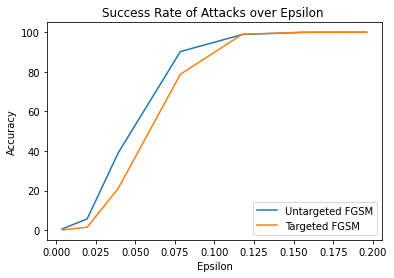

In [ ]:
plt.plot(new_epsilon, accuracyuntargeted, label = "Untargeted FGSM")
plt.plot(new_epsilon, accuracytargeted, label = "Targeted FGSM")
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Success Rate of Attacks over Epsilon ')
plt.legend()
plt.show() 

In [ ]:
from astropy.table import QTable, Table, Column
from astropy import units as u
t = Table()
t = Table([new_epsilon, accuracyuntargeted, accuracytargeted], names=('Epsilon', 'Untargeted FGSM', 'Targeted FGSM'))
print(t)

      Epsilon        Untargeted FGSM      Targeted FGSM   
------------------- ------------------ -------------------
0.00392156862745098 0.6243602865916076 0.09211873080859911
 0.0196078431372549  5.639713408393032   1.463664278403276
 0.0392156862745098  39.01740020470829  21.064483111566012
 0.0784313725490196   90.1944728761515   78.70010235414534
0.11764705882352941  98.82292732855682   98.99692937563971
 0.1568627450980392  99.92835209825998   99.94882292732856
0.19607843137254902  99.96929375639714   99.96929375639714


# Adversarial Retraining

Building the gradient for training data

In [ ]:
image_tensor3 = tf.convert_to_tensor(x_train,dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(image_tensor3)
    output3 = model(image_tensor3)
    loss3 = loss_fn(y_train, output3)
gradient3 = tape.gradient(loss3, image_tensor3)
signed_grad3 = tf.sign(gradient3)

Conducting the untargeted attack on training data

In [ ]:
accuracytargeted = np.zeros(shape=(len(epsilon)))
adversarial_arraytargettrain = x_train
adversarial_labels = y_train
for k in range(len(x_train)):
  image = x_train[k]  
  adversarial_arraytargettrain[k] = image + signed_grad3[k]*0.0392156862745098  #10/255
  adversarial_arraytargettrain[k] = tf.clip_by_value(adversarial_arraytargettrain[k], 0, 1)
  adversarial_labels[k] = y_train[k]

Reloading a clean dataset

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Appending the clean and perturbed datasets

In [ ]:
x_train = np.append(x_train,adversarial_arraytargettrain,axis=0)
y_train = np.append(y_train,adversarial_labels,axis=0)

Building a new model and using the appended dataset to train

In [ ]:
new_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
new_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
new_model.compile(optimizer='adam',
              loss=new_loss_fn,
              metrics=['accuracy'])

Retraining the model on the new training data

In [ ]:
new_model.fit(x_train, y_train,
          batch_size=32,
          epochs=10)

Epoch 1/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.1577 - accuracy: 0.9541
Epoch 2/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0591 - accuracy: 0.9814
Epoch 3/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0420 - accuracy: 0.9864
Epoch 4/10
3750/3750 [==============================] - 13s 4ms/step - loss: 0.0315 - accuracy: 0.9897
Epoch 5/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0278 - accuracy: 0.9907
Epoch 6/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0228 - accuracy: 0.9924
Epoch 7/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0219 - accuracy: 0.9927
Epoch 8/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0186 - accuracy: 0.9936
Epoch 9/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0178 - accuracy: 0.9939
Epoch 10/10
3750/3750 [==============================] - 10s 3ms/step - l

Calculating the training accuracy on the clean test set

In [ ]:
print("Loss,Accuracy of clean images on the Modified DNN:", new_model.evaluate(x=x_test, y=y_test, verbose=2))

313/313 - 0s - loss: 0.0892 - accuracy: 0.9810
Loss,Accuracy of clean images on the Modified DNN: [0.08923137187957764, 0.9810000061988831]


Running the attack on the clean test set

In [ ]:
image_tensor4 = tf.convert_to_tensor(x_test,dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(image_tensor4)
    output4 = new_model(image_tensor4)
    loss4 = new_loss_fn(y_test, output4)
gradient4 = tape.gradient(loss4, image_tensor4)
signed_grad4 = tf.sign(gradient4)

In [ ]:
adversarial_arrayRetrain = x_test
adversarial_retrainLabel = y_test
for i in range(len(epsilon)):
  for k in range(len(x_test)):
    image = x_test[k]  
    adversarial_arrayRetrain[k] = image + signed_grad4[k]*0.0392156862745098 #10/255
    adversarial_arrayRetrain[k] = tf.clip_by_value(adversarial_arrayRetrain[k], 0, 1)
    adversarial_retrainLabel[k] = y_test[k]


Calculating the accuracy on the attacked test set

In [ ]:
print("Loss,Accuracy of perturbed images on the Modified DNN:", new_model.evaluate(x=adversarial_arrayRetrain, y=adversarial_retrainLabel, verbose=2))

313/313 - 0s - loss: 227.2455 - accuracy: 2.0000e-04
Loss,Accuracy of perturbed images on the Modified DNN: [227.2455291748047, 0.00019999999494757503]


The adversarially retrained DNN is not robust against the attacks.

# References

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb#scrollTo=h3IKyzTCDNGo

https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb

https://medium.com/analytics-vidhya/implementing-adversarial-attacks-and-defenses-in-keras-tensorflow-2-0-cab6120c5715

https://github.com/soumyac1999/FGSM-Keras

https://github.com/EvolvedSquid/tutorials/blob/master/adversarial-attacks-defenses/adversarial-tutorial.ipynb

https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php

https://piazza.com/class/kelv94q140mpm?cid=110